In [306]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tools import add_constant
from statsmodels.regression.rolling import RollingOLS

from backtesting import Backtest

/Users/louisspencer/.pyenv/versions/3.10.0/lib/python3.10/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [492]:
%%time

df = pd.read_csv('price_data_1h.csv', index_col=None)[['time_period_end', 'price_open', 'price_high', 'price_low', 'price_close', 'asset_id_base', 'asset_id_quote', 'exchange_id']]
df = df[df.exchange_id.isin(['COINBASE', 'BINANCE', 'GEMINI', 'KRAKEN', 'GATEIO', 'KUCOIN', 'BITFINEX'])]
df['symbol_id'] = df.asset_id_base + '_' + df.asset_id_quote + '_' + df.exchange_id
df = df.set_index('time_period_end')

CPU times: user 22.8 s, sys: 4.86 s, total: 27.7 s
Wall time: 29 s


In [421]:
%%time

pivot = df.pivot_table(index = 'time_period_end', columns = 'symbol_id', values = 'price_close')
pivot

CPU times: user 4.89 s, sys: 985 ms, total: 5.88 s
Wall time: 5.9 s


symbol_id,1INCH_ETH_GATEIO,88MPH_ETH_GATEIO,A5T_ETH_GATEIO,AAVE_ETH_BINANCE,AAVE_ETH_GATEIO,AAVE_ETH_KRAKEN,ABT_ETH_GATEIO,ACH_ETH_GATEIO,ADA_ETH_BINANCE,ADA_ETH_COINBASE,...,ZIL_ETH_BINANCE,ZIL_ETH_GATEIO,ZIL_ETH_KUCOIN,ZKS_ETH_GATEIO,ZPT_ETH_GATEIO,ZRX_ETH_BINANCE,ZRX_ETH_BITFINEX,ZRX_ETH_GATEIO,ZRX_ETH_KUCOIN,ZSC_ETH_GATEIO
time_period_end,,,,,,,,,,,,,,,,,,,,,
2016-03-09 17:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-09 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-09 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-09 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-09 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-01 02:00:00,0.000423,NaN,0.000018,0.0544,0.0544,0.0545,0.000089,0.000008,0.000287,0.000287,...,0.000023,0.000023,0.000023,0.000036,2.280000e-07,NaN,0.000191,0.000191,0.000190,6.200000e-08
2022-09-01 03:00:00,0.000423,NaN,0.000018,0.0546,0.0544,0.0542,0.000089,0.000008,0.000288,0.000288,...,0.000023,0.000023,0.000023,0.000036,2.280000e-07,NaN,0.000191,0.000190,0.000190,6.200000e-08
2022-09-01 04:00:00,0.000423,0.00177,0.000018,0.0544,0.0543,NaN,0.000090,0.000008,0.000288,0.000287,...,0.000023,0.000023,0.000023,0.000036,2.290000e-07,NaN,0.000190,0.000190,0.000190,6.200000e-08


In [701]:
%%time

def run_cointegration_for_token(symbol_id, lookback, p_val_thresh = 0.05):
    
    def convert_to_usd(df, eth):
        m = df.merge(eth, on = 'time_period_end', how = 'inner')
        m[df.columns[0]] = m[df.columns[0]] * m['ETH_USD_COINBASE']
        return m[df.columns[0]].to_frame()
    
    cointegrated_tokens = []
        
    eth = pivot['ETH_USD_COINBASE'].fillna(method = 'pad').to_frame()
    
    token_data = pivot[symbol_id].to_frame().fillna(method = 'pad')
    token_data = convert_to_usd(token_data, eth)
        
    unique_pairs = pivot.columns
    
    for pair in unique_pairs:
        if 'ETH_USD' in pair or pair == symbol_id:
            continue
            
        price_data = pivot[pair].fillna(method = 'pad').to_frame()
        price_data = convert_to_usd(price_data, eth)
        
        m = price_data.merge(token_data, on = 'time_period_end', how = 'inner').iloc[-lookback:]
        
        if len(m) < lookback:
            continue
                
        X = m[symbol_id]
        X = add_constant(X)

        Y = m[pair]
        Y = add_constant(Y)
        
        r = m.corr().iloc[0][1]
        
        ols1 = sm.OLS(Y[pair], X).fit()
        ols2 = sm.OLS(X[symbol_id], Y).fit()
        
        best_ols = min([ols1, ols2], key = lambda x: adfuller(x.resid)[1])
        best_p_val = adfuller(best_ols.resid)[1]
        
        if best_ols == ols1 and best_p_val <= p_val_thresh:
            coint_dict = {
                'start':m.index[0],
                'end':m.index[-1],
                'X':symbol_id,
                'Y':pair
            }
            cointegrated_tokens.append(coint_dict)
            
        elif best_ols == ols2 and best_p_val <= p_val_thresh:
            coint_dict = {
                'start':m.index[0],
                'end':m.index[-1],
                'X':pair,
                'Y':symbol_id
            }
            cointegrated_tokens.append(coint_dict)
            
        print()
        print('{} / {} ({} - {}):'.format(symbol_id, pair, m.index[0], m.index[-1]))
        print('correlation: {}'.format(r))
        print('adf p-val: {}'.format(best_p_val))
        
    return cointegrated_tokens
                

cointegrated_tokens = run_cointegration_for_token('ALBT_ETH_KUCOIN', 24 * 30)



ALBT_ETH_KUCOIN / 1INCH_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.8971276466238262
adf p-val: 0.07245105285588645

ALBT_ETH_KUCOIN / 88MPH_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.2817096457011843
adf p-val: 0.019837452120276454

ALBT_ETH_KUCOIN / A5T_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.7859271339447134
adf p-val: 2.943496355928354e-06

ALBT_ETH_KUCOIN / AAVE_ETH_BINANCE (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.8780905121266391
adf p-val: 0.0899990658476425

ALBT_ETH_KUCOIN / AAVE_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.8785006384473618
adf p-val: 0.07918850077604284

ALBT_ETH_KUCOIN / AAVE_ETH_KRAKEN (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.8781619839428236
adf p-val: 0.08362265779899847

ALBT_ETH_KUCOIN / ABT_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.4496987749040682
adf p-val: 0.11593207603851


ALBT_ETH_KUCOIN / AVA_ETH_KUCOIN (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.27347720992558394
adf p-val: 0.002534861150560254

ALBT_ETH_KUCOIN / AXIS_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.7692692291858828
adf p-val: 0.014261269675761738

ALBT_ETH_KUCOIN / AXPR_ETH_KUCOIN (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.7245782030578197
adf p-val: 0.0865856620758958

ALBT_ETH_KUCOIN / AXS_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.9048258607665375
adf p-val: 0.008904136810572274

ALBT_ETH_KUCOIN / BAC_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.41926247722826976
adf p-val: 6.3931020061796e-07

ALBT_ETH_KUCOIN / BADGER_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.7928514164782876
adf p-val: 0.010578607469509664

ALBT_ETH_KUCOIN / BAGS_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.3692799569861212
adf p-val: 0.2188797439494

/Users/louisspencer/.pyenv/versions/3.10.0/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:940: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/louisspencer/.pyenv/versions/3.10.0/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:940: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2



ALBT_ETH_KUCOIN / BTT_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: nan
adf p-val: nan

ALBT_ETH_KUCOIN / BXC_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.7807433571336869
adf p-val: 0.04002553116592837

ALBT_ETH_KUCOIN / BXH_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: -0.4996579232735296
adf p-val: 0.05040990323159446

ALBT_ETH_KUCOIN / CAKE_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.8124150590209709
adf p-val: 0.11440090275531767

ALBT_ETH_KUCOIN / CAPP_ETH_KUCOIN (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.7942620939016896
adf p-val: 0.05058320174918838

ALBT_ETH_KUCOIN / CARDS_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.7950381343220597
adf p-val: 0.24090653182943855

ALBT_ETH_KUCOIN / CBK_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.9023093392934111
adf p-val: 0.02635942518410514

ALBT_ETH_KUCOIN / CELR_ETH_GATE


ALBT_ETH_KUCOIN / DCR_ETH_KUCOIN (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.6801348619828175
adf p-val: 3.077349666995401e-05

ALBT_ETH_KUCOIN / DDD_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.8945120325902282
adf p-val: 0.002174869936897524

ALBT_ETH_KUCOIN / DDIM_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.7336855651903414
adf p-val: 0.17882536472847038

ALBT_ETH_KUCOIN / DEGO_ETH_KUCOIN (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.8075625268244214
adf p-val: 0.005805866712216651

ALBT_ETH_KUCOIN / DENT_ETH_BINANCE (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.9255236804951019
adf p-val: 0.0032549067116261076

ALBT_ETH_KUCOIN / DENT_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.9257850353338519
adf p-val: 0.005925157102638819

ALBT_ETH_KUCOIN / DENT_ETH_KUCOIN (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.9254764580872726
adf p-val: 0.00139452730


ALBT_ETH_KUCOIN / ESS_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.6676868875684999
adf p-val: 0.02400683554854228

ALBT_ETH_KUCOIN / ETC_ETH_BINANCE (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.8048576566681593
adf p-val: 0.09574379275187239

ALBT_ETH_KUCOIN / ETC_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.8036478813552035
adf p-val: 0.09786056600104925

ALBT_ETH_KUCOIN / ETC_ETH_KRAKEN (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.7950702451764126
adf p-val: 0.08296890599199525

ALBT_ETH_KUCOIN / ETC_ETH_KUCOIN (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.8051136644780262
adf p-val: 0.026119699878979663

ALBT_ETH_KUCOIN / ETH2X_ETH_BITFINEX (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.790133193387324
adf p-val: 0.2606911233038167

ALBT_ETH_KUCOIN / ETH2_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.8041338988079259
adf p-val: 0.03221862709965303




ALBT_ETH_KUCOIN / GLM_ETH_BINANCE (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.7036607618904709
adf p-val: 0.006667144006994849

ALBT_ETH_KUCOIN / GLM_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.7090371953785608
adf p-val: 0.006992506369810077

ALBT_ETH_KUCOIN / GLQ_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.6878775210881881
adf p-val: 0.03804983992085397

ALBT_ETH_KUCOIN / GMAT_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.5390048027415169
adf p-val: 0.00034408983714957

ALBT_ETH_KUCOIN / GMB_ETH_KUCOIN (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.8501003900885069
adf p-val: 0.06119765975077953

ALBT_ETH_KUCOIN / GNO_ETH_KRAKEN (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.6144619301985385
adf p-val: 0.18101843881590907

ALBT_ETH_KUCOIN / GNX_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.0616780181169308
adf p-val: 0.017202997939572466




ALBT_ETH_KUCOIN / KEEP_ETH_KRAKEN (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.9082987215012278
adf p-val: 0.0003093855526656859

ALBT_ETH_KUCOIN / KEY_ETH_BINANCE (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.8726958527980896
adf p-val: 0.007494302370991234

ALBT_ETH_KUCOIN / KEY_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.8734008205726399
adf p-val: 0.0025811912213575755

ALBT_ETH_KUCOIN / KEY_ETH_KUCOIN (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.8741308439836454
adf p-val: 0.004104239281356938

ALBT_ETH_KUCOIN / KIF_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: -0.606732742552439
adf p-val: 0.00281713805668831

ALBT_ETH_KUCOIN / KIMCHI_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: -0.3293690992719306
adf p-val: 0.0005355941641921982

ALBT_ETH_KUCOIN / KINE_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.601713999722696
adf p-val: 1.1544087246


ALBT_ETH_KUCOIN / LYM_ETH_KUCOIN (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: -0.4439992901748463
adf p-val: 0.11391251461239471

ALBT_ETH_KUCOIN / LYXE_ETH_KUCOIN (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.8948941234283285
adf p-val: 0.010438054875773664

ALBT_ETH_KUCOIN / MAHA_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.7641495619742383
adf p-val: 0.04894758207979699

ALBT_ETH_KUCOIN / MANA_ETH_BINANCE (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.9316006806628131
adf p-val: 0.0018068457912972591

ALBT_ETH_KUCOIN / MANA_ETH_COINBASE (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.9317986401175609
adf p-val: 0.0017434035152058003

ALBT_ETH_KUCOIN / MANA_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.9314748983968086
adf p-val: 0.0017271911453109966

ALBT_ETH_KUCOIN / MANA_ETH_KRAKEN (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.9317352089579277
adf p-val: 0.0015619


ALBT_ETH_KUCOIN / NIM_ETH_KUCOIN (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.7887011300747174
adf p-val: 0.08437423913704017

ALBT_ETH_KUCOIN / NKN_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.5525557273363807
adf p-val: 0.0003213891924348823

ALBT_ETH_KUCOIN / NMR_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.8375651492508894
adf p-val: 0.0006056059928479762

ALBT_ETH_KUCOIN / NMT_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.7838798519179365
adf p-val: 0.07149703052195501

ALBT_ETH_KUCOIN / NOIA_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.8163571155283711
adf p-val: 0.09954862175552698

ALBT_ETH_KUCOIN / NORD_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.8900467986604905
adf p-val: 0.0004723495373209553

ALBT_ETH_KUCOIN / NRG_ETH_KUCOIN (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.7938587009053466
adf p-val: 0.0298506779003312


ALBT_ETH_KUCOIN / PIVX_ETH_KUCOIN (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.7950381343220594
adf p-val: 0.2409065318294797

ALBT_ETH_KUCOIN / PKF_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.9000290924706247
adf p-val: 0.014820343530156444

ALBT_ETH_KUCOIN / PMON_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.1300543907082899
adf p-val: 0.030337533428829614

ALBT_ETH_KUCOIN / PNK_ETH_BITFINEX (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.7950381343220638
adf p-val: 0.2409065318294734

ALBT_ETH_KUCOIN / PNK_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.8848136300841093
adf p-val: 0.019898881151686303

ALBT_ETH_KUCOIN / PNL_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.0022351734900494208
adf p-val: 0.483290239456297

ALBT_ETH_KUCOIN / PNT_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.875605986231725
adf p-val: 0.14458691225508397




ALBT_ETH_KUCOIN / RING_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.8392308452988403
adf p-val: 0.09883342538615553

ALBT_ETH_KUCOIN / RLC_ETH_BINANCE (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.05073994981165823
adf p-val: 0.07335435137117487

ALBT_ETH_KUCOIN / RLC_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.04853593788787001
adf p-val: 0.13130805784202598

ALBT_ETH_KUCOIN / RLY_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.8653240687801547
adf p-val: 0.02213195103503898

ALBT_ETH_KUCOIN / RNDR_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.884107068931417
adf p-val: 0.000990883604938627

ALBT_ETH_KUCOIN / ROOK_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.5453945068476729
adf p-val: 0.38878443707641297

ALBT_ETH_KUCOIN / ROOM_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.8063036305158428
adf p-val: 0.00264903951886504


ALBT_ETH_KUCOIN / STORJ_ETH_KRAKEN (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.9106004479372236
adf p-val: 0.02504339769738871

ALBT_ETH_KUCOIN / STOX_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.08219469850755876
adf p-val: 1.2635044863993665e-09

ALBT_ETH_KUCOIN / STRAX_ETH_BINANCE (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.8923937184217243
adf p-val: 0.005203039529880499

ALBT_ETH_KUCOIN / STRAX_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.8883707460289066
adf p-val: 0.0009521203832358223

ALBT_ETH_KUCOIN / STRK_ETH_KUCOIN (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.834117337098598
adf p-val: 0.004409444053542933

ALBT_ETH_KUCOIN / STRONG_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.901343834090319
adf p-val: 0.008360155672908475

ALBT_ETH_KUCOIN / STX_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.921087642590793
adf p-val: 0.017939


ALBT_ETH_KUCOIN / UMB_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.26917100288113516
adf p-val: 0.06504852555411292

ALBT_ETH_KUCOIN / UMX_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.7950381343220635
adf p-val: 0.2409065318294532

ALBT_ETH_KUCOIN / UNFI_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.652830509128192
adf p-val: 0.16404155088247385

ALBT_ETH_KUCOIN / UNISTAKE_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.790314611184018
adf p-val: 0.022123350858599632

ALBT_ETH_KUCOIN / UNI_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.8780958499986751
adf p-val: 0.037848949930386185

ALBT_ETH_KUCOIN / UNI_ETH_KRAKEN (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.8771588167461638
adf p-val: 0.03875016941902994

ALBT_ETH_KUCOIN / UNN_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.8156185905457967
adf p-val: 0.09089574846839077



ALBT_ETH_KUCOIN / XTZ_ETH_KRAKEN (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.9035952584220137
adf p-val: 0.015221060596570765

ALBT_ETH_KUCOIN / XVG_ETH_BINANCE (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.8616915921321588
adf p-val: 0.17552823150145497

ALBT_ETH_KUCOIN / XYM_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.8560020880571478
adf p-val: 0.012224000036233496

ALBT_ETH_KUCOIN / XYO_ETH_KUCOIN (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.5899537426852348
adf p-val: 0.03264398585243239

ALBT_ETH_KUCOIN / YAM_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.8417775615709082
adf p-val: 0.004006505074200302

ALBT_ETH_KUCOIN / YFDAI_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.85538570945573
adf p-val: 0.0009660737051305927

ALBT_ETH_KUCOIN / YFII_ETH_GATEIO (2022-08-02 07:00:00 - 2022-09-01 06:00:00):
correlation: 0.7918694916269544
adf p-val: 0.03326870933247213

In [705]:
cointegrated_tokens

[{'start': '2022-08-02 07:00:00',
  'end': '2022-09-01 06:00:00',
  'X': 'ALBT_ETH_KUCOIN',
  'Y': '88MPH_ETH_GATEIO'},
 {'start': '2022-08-02 07:00:00',
  'end': '2022-09-01 06:00:00',
  'X': 'ALBT_ETH_KUCOIN',
  'Y': 'A5T_ETH_GATEIO'},
 {'start': '2022-08-02 07:00:00',
  'end': '2022-09-01 06:00:00',
  'X': 'ALBT_ETH_KUCOIN',
  'Y': 'ACH_ETH_GATEIO'},
 {'start': '2022-08-02 07:00:00',
  'end': '2022-09-01 06:00:00',
  'X': 'ADA_ETH_BINANCE',
  'Y': 'ALBT_ETH_KUCOIN'},
 {'start': '2022-08-02 07:00:00',
  'end': '2022-09-01 06:00:00',
  'X': 'ADA_ETH_COINBASE',
  'Y': 'ALBT_ETH_KUCOIN'},
 {'start': '2022-08-02 07:00:00',
  'end': '2022-09-01 06:00:00',
  'X': 'ADA_ETH_KRAKEN',
  'Y': 'ALBT_ETH_KUCOIN'},
 {'start': '2022-08-02 07:00:00',
  'end': '2022-09-01 06:00:00',
  'X': 'ALBT_ETH_KUCOIN',
  'Y': 'ADX_ETH_BINANCE'},
 {'start': '2022-08-02 07:00:00',
  'end': '2022-09-01 06:00:00',
  'X': 'ALBT_ETH_KUCOIN',
  'Y': 'ADX_ETH_GATEIO'},
 {'start': '2022-08-02 07:00:00',
  'end': '2022-0

In [734]:
def convert_to_usd(df, eth):
    m = df.merge(eth, on = 'time_period_end', how = 'inner')
    m[df.columns[0]] = m[df.columns[0]] * m['ETH_USD_COINBASE']
    return m[df.columns[0]].to_frame()
    
eth = pivot['ETH_USD_COINBASE']

X = pivot['ALBT_ETH_KUCOIN'].to_frame().iloc[-24*180:].fillna(method = 'pad')
X = convert_to_usd(X, eth)
X_const = add_constant(X)

Y = pivot['QNT_ETH_GATEIO'].to_frame().iloc[-24*180:].fillna(method = 'pad')
Y = convert_to_usd(Y, eth)

rolling_hedge_ratios = RollingOLS(endog = Y, exog = X_const, window = 24).fit().params[X.columns[0]]
rolling_spread = Y[Y.columns[0]] - rolling_hedge_ratios * X[X.columns[0]]

rolling_mean = rolling_spread.rolling(window = 24).mean()
rolling_std = rolling_spread.rolling(window = 24).std()
rolling_z_score = (rolling_spread - rolling_mean) / rolling_std

/Users/louisspencer/.pyenv/versions/3.10.0/lib/python3.10/site-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in double_scalars
  s2 = ssr / (nobs - tot_params)


In [735]:
begin = rolling_z_score.fillna(method = 'pad').index[0]

x = X[X.columns[0]][X.index >= begin]
y = Y[Y.columns[0]][Y.index >= begin]
z = rolling_z_score[rolling_z_score.index >= begin]

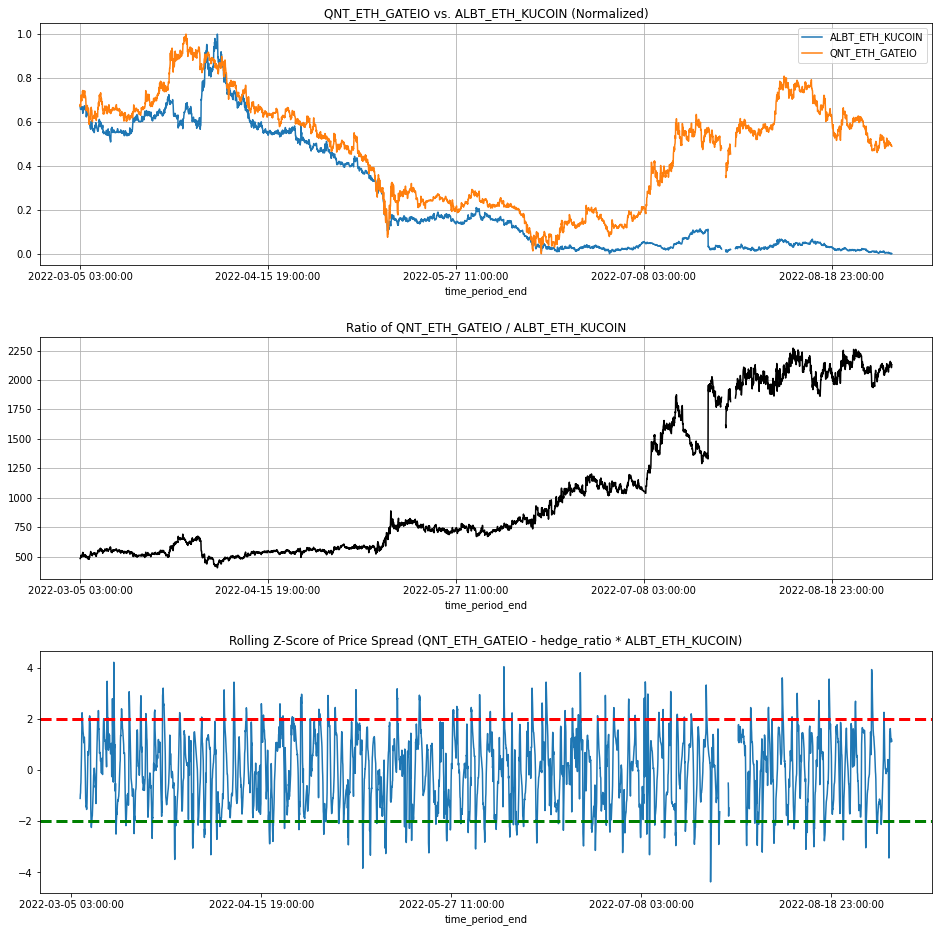

In [736]:
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (16, 16))
fig.subplots_adjust(hspace=.3)

plt.subplot(3, 1, 1)
((x - x.min()) / (x.max() - x.min())).plot(label = X.columns[0])
((y - y.min()) / (y.max() - y.min())).plot(label = Y.columns[0], grid = True)
plt.title('{} vs. {} (Normalized)'.format(Y.columns[0], X.columns[0]))
plt.legend()

plt.subplot(3, 1, 2)
(y / x).plot(title = 'Ratio of {} / {}'.format(Y.columns[0], X.columns[0]), c = 'black', grid = True)

plt.subplot(3, 1, 3)
z.plot(title = 'Rolling Z-Score of Price Spread ({} - hedge_ratio * {})'.format(Y.columns[0], X.columns[0]))
plt.axhline(-2, c = 'green', linestyle = '--', lw = 3)
plt.axhline(2, c = 'red', linestyle = '--', lw = 3)

In [737]:
from backtesting import Strategy
from backtesting.lib import crossover, cross

import pandas as pd
import numpy as np

class PairsTrading(Strategy):
    ########### INDICATOR PARAMETERS ##################
    z_window = 24
    hedge_ratio_window = 24
    
    z_thresh_upper = 1
    z_thresh_lower = -1
    
    X = 'ALBT_ETH_KUCOIN'
    Y = 'QNT_ETH_GATEIO'
    ###################################################
        
    def z(data, window):
        data = pd.Series(data)
        return (data - data.rolling(window = window).mean()) / data.rolling(window = window).std()
    
    def name():
        return 'PairsTrading'

    def update_hyperparameters(params_dict):
        for param_name, optimal_param_value in params_dict.items():
            setattr(PairsTrading, param_name, optimal_param_value)

    def init(self):
        # Initiate parent classes
        super().init()
        
        # Define indicator value arrays
        X = pd.DataFrame(add_constant(self.data[PairsTrading.X]))
        Y = pd.DataFrame(self.data[PairsTrading.Y])
        
        rolling_hedge_ratio = RollingOLS(endog = Y, exog = X, window = self.hedge_ratio_window).fit().params[X.columns[0]]
        spread = self.data[PairsTrading.Y] - rolling_hedge_ratio * self.data[PairsTrading.X]
        
        self.rolling_spread_z_score = self.I(
            PairsTrading.z,
            spread,
            self.z_window
        )

    # Define how the backtest acts at each step of iterating through the dataset
    def next(self):        
        entry_signal = (
            not crossover(self.rolling_spread_z_score, self.z_thresh_lower) and 
            cross(self.rolling_spread_z_score, self.z_thresh_lower)
        )
        exit_signal = crossover(self.rolling_spread_z_score, self.z_thresh_upper)

        # Close position
        if (self.position and exit_signal):
            self.position.close()

        # Open position
        elif (not self.position) and entry_signal:
            self.buy(sl = self.data.Close[-1] * 0.9)
            

In [738]:
backtest_result_cols = [
    '_strategy',
    'Start', 'End', 'Duration', 'Equity Final [$]', 
    'Return [%]', 'Buy & Hold Return [%]', 'Sharpe Ratio', 'Sortino Ratio', 
    'Calmar Ratio', 'Max. Drawdown [%]', 'Avg. Drawdown [%]', 'Max. Drawdown Duration',
    'Avg. Drawdown Duration', '# Trades', 'Win Rate [%]', 'Avg. Trade [%]', 
    'Best Trade [%]', 'Worst Trade [%]', 'Max. Trade Duration', 'Avg. Trade Duration', '_equity_curve'
]

In [739]:
%%time

x_pair = df[df['symbol_id'] == PairsTrading.X][['price_open', 'price_close']]
x_pair['price_open'] = convert_to_usd(x_pair['price_open'].to_frame(), eth)
x_pair['price_close'] = convert_to_usd(x_pair['price_close'].to_frame(), eth)

y_pair = df[df['symbol_id'] == PairsTrading.Y][['price_open', 'price_close']]
y_pair['price_open'] = convert_to_usd(y_pair['price_open'].to_frame(), eth)
y_pair['price_close'] = convert_to_usd(y_pair['price_close'].to_frame(), eth)

merge = x_pair.merge(y_pair, on = 'time_period_end', how = 'inner').iloc[-24*30:].fillna(method = 'pad')

backtest_data = pd.DataFrame()
                           
backtest_data['Open'] = merge['price_open_y'] / merge['price_open_x']
backtest_data['Close'] = merge['price_close_y'] / merge['price_close_x']
backtest_data['Low'] = backtest_data['Open']
backtest_data['High'] = backtest_data['Close']

backtest_data[PairsTrading.X] = merge['price_close_x']
backtest_data[PairsTrading.Y] = merge['price_close_y']

backtest_data.index = pd.to_datetime(merge.index)

optimize_dict = {
    'z_window':[6, 12, 24, 24*2, 24*3, 24*4, 24*5, 24*6, 24*7],
    'hedge_ratio_window':[6, 12, 24, 24*2, 24*3, 24*4, 24*5, 24*6, 24*7],
    'z_thresh_upper':[0.5, 1, 1.5, 2, 2.5, 3],
    'z_thresh_lower':[-0.5, -1, -1.5, -2, -2.5, -3]
}

in_sample_backtest = Backtest(
    data = backtest_data,
    strategy = PairsTrading,
    cash = 10000,
    commission = 0.01,
    trade_on_close = True
)

stats_for_strat = in_sample_backtest.optimize(
    **optimize_dict,
    maximize = 'Equity Final [$]'
)

buy_and_hold_x = (backtest_data[PairsTrading.X].iloc[-1] - backtest_data[PairsTrading.X].iloc[0]) / backtest_data[PairsTrading.X].iloc[0]
buy_and_hold_x = round(buy_and_hold_x * 100, 2)

buy_and_hold_y = (backtest_data[PairsTrading.Y].iloc[-1] - backtest_data[PairsTrading.Y].iloc[0]) / backtest_data[PairsTrading.Y].iloc[0]
buy_and_hold_y = round(buy_and_hold_y * 100, 2)

max_buy_and_hold = max(buy_and_hold_x, buy_and_hold_y)


/Users/louisspencer/.pyenv/versions/3.10.0/lib/python3.10/site-packages/backtesting/backtesting.py:1488: UserWarning: Searching for best of 2916 configurations.
  output = _optimize_grid()
/Users/louisspencer/.pyenv/versions/3.10.0/lib/python3.10/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "
/Users/louisspencer/.pyenv/versions/3.10.0/lib/python3.10/site-packages/backtesting/_stats.py:122: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501
/Users/louisspencer/.pyenv/versions/3.10.0/lib/python3.10/site-packages/backtesting/_stats.py:122: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Rati

CPU times: user 4min 30s, sys: 1.11 s, total: 4min 31s
Wall time: 2min 17s


In [740]:
in_sample_backtest.plot(
    results = stats_for_strat, 
    open_browser = False,
    filename = '/Users/louisspencer/Desktop/{}_{}.html'.format(PairsTrading.Y, PairsTrading.X),
    reverse_indicators = True,
    plot_equity = False,
    plot_return = True
)

Row(id='29225', ...)

In [741]:
stats_for_strat['Buy & Hold Return [%]'] = max_buy_and_hold
stats_for_strat = stats_for_strat.T.to_frame()
stats_for_strat

,0
Start,2022-08-01 20:00:00
End,2022-09-01 06:00:00
Duration,30 days 10:00:00
Exposure Time [%],39.166667
Equity Final [$],13423.465785
Equity Peak [$],13423.465785
Return [%],34.234658
Buy & Hold Return [%],-7.0
Return (Ann.) [%],2773.798276
Volatility (Ann.) [%],1640.109635
